<a href="https://colab.research.google.com/github/mazinkamal134/DS_MRP_2024/blob/main/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

### Mount the drive

In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Global Paramaters

In [ ]:
# Global parameters
tweetsDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Tweets"
authorsDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Authors"
musicDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Music"

### Read the data

#### Original dataset

In [ ]:
# Read the datasets
tweetsDf = pd.read_parquet(os.path.join(tweetsDir, "processedTweets.parquet"))
authorsControl = pd.read_csv(os.path.join(authorsDir, "authors_control.csv"))
authorsControl["group"] = "control"
authorsTreatment = pd.read_csv(os.path.join(authorsDir, "authors_treatment.csv"))
authorsTreatment["group"] = "treatment"
authorsDf = pd.concat([authorsControl, authorsTreatment], ignore_index=True)
authorsDf["id"] = authorsDf["id"].astype(str)
del authorsControl, authorsTreatment
musicDf = pd.read_csv(os.path.join(musicDir, "music.csv"))

# Check
print("Authors Df shape:", authorsDf.shape)
print("Tweets Df shape:", tweetsDf.shape)
print("Music Df shape:", musicDf.shape)

In [ ]:
authorsDf.group.value_counts()

group
control      4362
treatment    2251
Name: count, dtype: int64

In [ ]:
tweetsUsers = tweetsDf[tweetsDf.author_since.notna()].author_id.unique()
authorsUsers = authorsDf.id.unique()
print("Tweets users:", len(tweetsUsers))
print("Authors users:", len(authorsUsers))
missingUsers = list(set(authorsUsers) - set(tweetsUsers))
print("Missing users:", len(missingUsers))

Tweets users: 5612
Authors users: 6613
Missing users: 1001


#### Curated dataset

In [ ]:
# Filter the tweets
# 3 Main disorders, english, timeline, with stress scores, and known author
masterDf = tweetsDf[(tweetsDf.disorder.isin(['depression', 'anxiety', 'ptsd'])) &
                            (tweetsDf.lang == 'en') &
                            #(tweetsDf.tweet_type == 'timeline') &
                            (tweetsDf.stress_score.notna()) &
                            (tweetsDf.author_since.notna()) & # Author id with 3+ music sessions
                            (tweetsDf.cleaned_text.notna())]
# Check
print("Shape of the master:", masterDf.shape)
masterDf[masterDf.author_since.notna()].groupby(by = ["disorder", "group"]).author_id.nunique().reset_index()

Shape of the master: (8025360, 29)


,disorder,group,author_id
0,anxiety,0,966
1,anxiety,1,468
2,depression,0,2027
3,depression,1,999
4,ptsd,0,764
5,ptsd,1,388


### EDA on the orginal dataset

In [ ]:
# Update the tweets df to include only tweets with known users
tweetsDf = tweetsDf[tweetsDf.author_since.notna()]

#### Basic Stats

In [ ]:
# Number of users per disorder
usersPerDisorder = tweetsDf.groupby('disorder')['author_id'].nunique()

# Calculate total tweets per disorder
totalTweetsPerDisorder = tweetsDf['disorder'].value_counts()

# Calculate average tweets per user
avgTweetsPerUser = totalTweetsPerDisorder / usersPerDisorder

# Calculate min and max tweets per user
minTweetsPerUser = tweetsDf.groupby('disorder')['author_id'].value_counts().groupby(level=0).min()
maxTweetsPerUser = tweetsDf.groupby('disorder')['author_id'].value_counts().groupby(level=0).max()

# Calculate standard deviation of tweets per user
stdTweetsPerUser = tweetsDf.groupby('disorder')['author_id'].value_counts().groupby(level=0).std()

# Calculate word count per tweet
tweetsDf['word_count'] = tweetsDf['cleaned_text'].astype(str).str.split().apply(len)

# Calculate min, max, and std of words per tweet
minWords = tweetsDf.groupby('disorder')['word_count'].min()
maxWords = tweetsDf.groupby('disorder')['word_count'].max()
stdWords = tweetsDf.groupby('disorder')['word_count'].std()

# 9. Average words per tweet
avgWordsPerTweet = tweetsDf.groupby('disorder')['word_count'].mean()

# 9. Earliest/Latest tweet date
earliestTweetDate = tweetsDf.groupby('disorder')['created_at'].min()
latestTweetDate = tweetsDf.groupby('disorder')['created_at'].max()

# 9. Create summary dataframe
summaryDf = pd.DataFrame({
    'Number of Users': usersPerDisorder,
    'Total Tweets': totalTweetsPerDisorder,
    'Earliest Tweet Date': earliestTweetDate,
    'Latest Tweet Date': latestTweetDate,
    'Average Tweets per User': avgTweetsPerUser,
    'Min Tweets per User': minTweetsPerUser,
    'Max Tweets per User': maxTweetsPerUser,
    'Std Tweets per User': stdTweetsPerUser,
    'Average Words per Tweet': avgWordsPerTweet,
    'Min Words per Tweet': minWords,
    'Max Words per Tweet': maxWords,
    'Std Words per Tweet': stdWords
}).round(2)

# Print the summary dataframe
summaryDf

,Number of Users,Total Tweets,Earliest Tweet Date,Latest Tweet Date,Average Tweets per User,Min Tweets per User,Max Tweets per User,Std Tweets per User,Average Words per Tweet,Min Words per Tweet,Max Words per Tweet,Std Words per Tweet
disorder,,,,,,,,,,,,
anxiety,1509,2502418,2009-01-20 00:39:23,2022-02-11 17:03:05,1658.33,1,3251,1157.22,12.75,1,130,13.25
bipolar,666,1138366,2008-08-13 22:08:58,2022-02-11 16:43:21,1709.26,1,3253,1121.25,13.07,1,77,13.12
borderline,179,303844,2009-06-30 10:21:07,2022-02-11 04:54:11,1697.45,1,3245,1114.35,14.19,1,78,13.96
depression,3114,5379933,2008-11-17 03:04:56,2022-02-10 19:44:05,1727.66,1,3251,1132.28,12.22,1,109,12.82
panic,56,92558,2012-03-02 06:14:12,2022-02-11 00:44:40,1652.82,1,3247,1173.81,14.73,1,69,14.20
ptsd,1184,2078464,2007-11-20 09:15:35,2022-02-11 07:25:42,1755.46,1,3251,1113.86,14.71,1,92,14.24


#### Charts

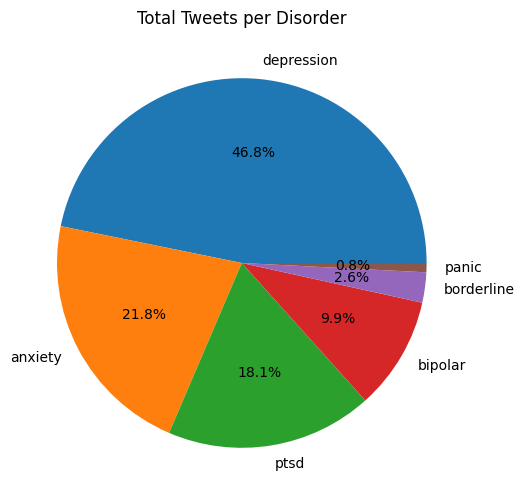

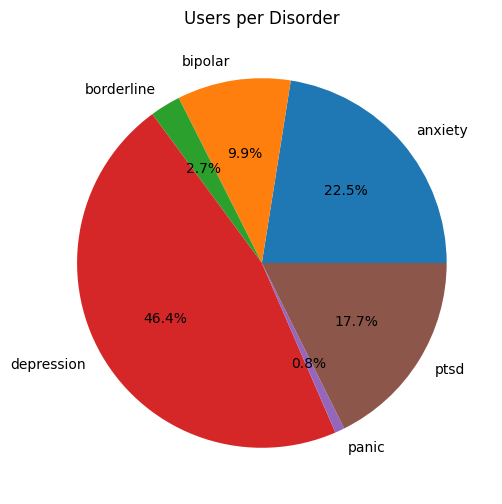

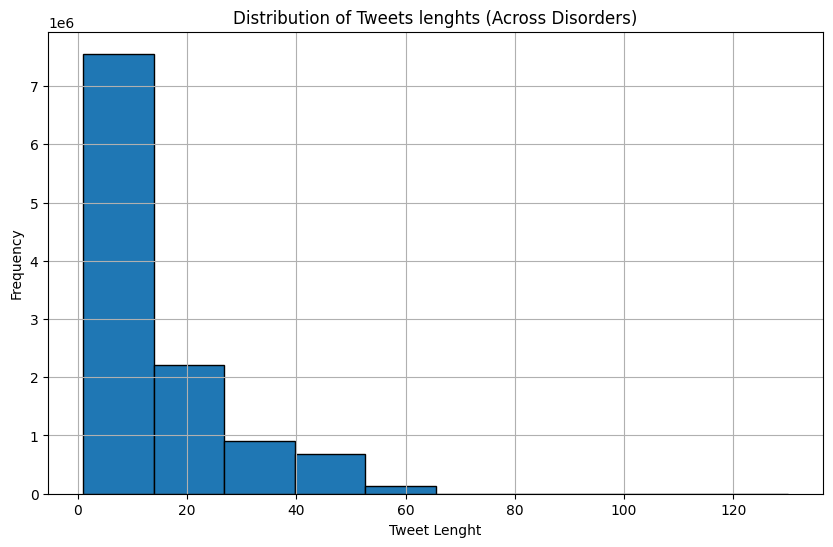

<ipython-input-32-f3c5274659a7>:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(disorder, (summary_df['Average Tweets per User'][i], summary_df['Average Words per Tweet'][i]))


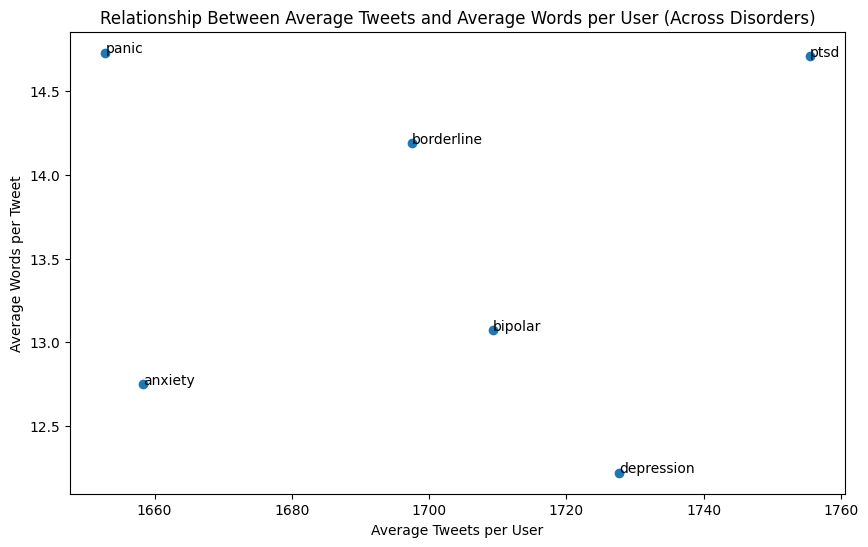

In [ ]:
# Pie chart: Total tweets per disorder
plt.figure(figsize=(10, 6))
plt.pie(totalTweetsPerDisorder, labels=totalTweetsPerDisorder.index, autopct='%1.1f%%')
plt.title('Total Tweets per Disorder')
plt.show()

# Pie chart: Users per disorder
plt.figure(figsize=(10, 6))
plt.pie(usersPerDisorder, labels=usersPerDisorder.index, autopct='%1.1f%%')
plt.title('Users per Disorder')
plt.show()

# Histogram: Distribution of tweet lengths
plt.figure(figsize=(10, 6))
tweetsDf['word_count'].hist(bins=10, edgecolor='k')
plt.title('Distribution of Tweets lenghts (Across Disorders)')
plt.xlabel('Tweet Lenght')
plt.ylabel('Frequency')
plt.show()

# Scatter plot: Average tweets per user vs. average words per tweet
plt.figure(figsize=(10, 6))
plt.scatter(summaryDf['Average Tweets per User'], summaryDf['Average Words per Tweet'])
plt.title('Relationship Between Average Tweets and Average Words per User (Across Disorders)')
plt.xlabel('Average Tweets per User')
plt.ylabel('Average Words per Tweet')
for i, disorder in enumerate(summaryDf.index):
    plt.annotate(disorder, (summaryDf['Average Tweets per User'][i], summaryDf['Average Words per Tweet'][i]))
plt.show()


### EDA on the curated dataset

#### Basic Stats

In [ ]:
# Number of users per disorder
usersPerDisorder = masterDf.groupby('disorder')['author_id'].nunique()

# Calculate total tweets per disorder
totalTweetsPerDisorder = masterDf['disorder'].value_counts()

# Calculate average tweets per user
avgTweetsPerUser = totalTweetsPerDisorder / usersPerDisorder

# Calculate min and max tweets per user
minTweetsPerUser = masterDf.groupby('disorder')['author_id'].value_counts().groupby(level=0).min()
maxTweetsPerUser = masterDf.groupby('disorder')['author_id'].value_counts().groupby(level=0).max()

# Calculate standard deviation of tweets per user
stdTweetsPerUser = masterDf.groupby('disorder')['author_id'].value_counts().groupby(level=0).std()

# Calculate word count per tweet
masterDf['word_count'] = masterDf['cleaned_text'].astype(str).str.split().apply(len)

# Calculate min, max, and std of words per tweet
minWords = masterDf.groupby('disorder')['word_count'].min()
maxWords = masterDf.groupby('disorder')['word_count'].max()
stdWords = masterDf.groupby('disorder')['word_count'].std()

# Average words per tweet
avgWordsPerTweet = masterDf.groupby('disorder')['word_count'].mean()

# Earliest/Latest tweet date
earliestTweetDate = masterDf.groupby('disorder')['created_at'].min()
latestTweetDate = masterDf.groupby('disorder')['created_at'].max()

# Create summary dataframe
summaryDf = pd.DataFrame({
    'Number of Users': usersPerDisorder,
    'Total Tweets': totalTweetsPerDisorder,
    'Earliest Tweet Date': earliestTweetDate,
    'Latest Tweet Date': latestTweetDate,
    'Average Tweets per User': avgTweetsPerUser,
    'Min Tweets per User': minTweetsPerUser,
    'Max Tweets per User': maxTweetsPerUser,
    'Std Tweets per User': stdTweetsPerUser,
    'Average Words per Tweet': avgWordsPerTweet,
    'Min Words per Tweet': minWords,
    'Max Words per Tweet': maxWords,
    'Std Words per Tweet': stdWords
}).round(2)

# Print the summary dataframe
summaryDf

<ipython-input-18-6a06854cc875>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masterDf['word_count'] = masterDf['cleaned_text'].astype(str).str.split().apply(len)


,Number of Users,Total Tweets,Earliest Tweet Date,Latest Tweet Date,Average Tweets per User,Min Tweets per User,Max Tweets per User,Std Tweets per User,Average Words per Tweet,Min Words per Tweet,Max Words per Tweet,Std Words per Tweet
disorder,,,,,,,,,,,,
anxiety,1434,2007548,2009-01-20 00:39:23,2022-02-11 17:03:05,1399.96,1,3248,1018.03,15.42,1,130,13.40
depression,3026,4217666,2008-11-17 03:04:56,2022-02-10 19:24:54,1393.81,1,3248,1011.15,14.64,1,109,12.85
ptsd,1152,1800146,2007-11-20 09:15:35,2022-02-11 07:25:42,1562.63,1,3232,981.27,16.80,1,92,14.18


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


#### Box Plots: Avg. Stress Score

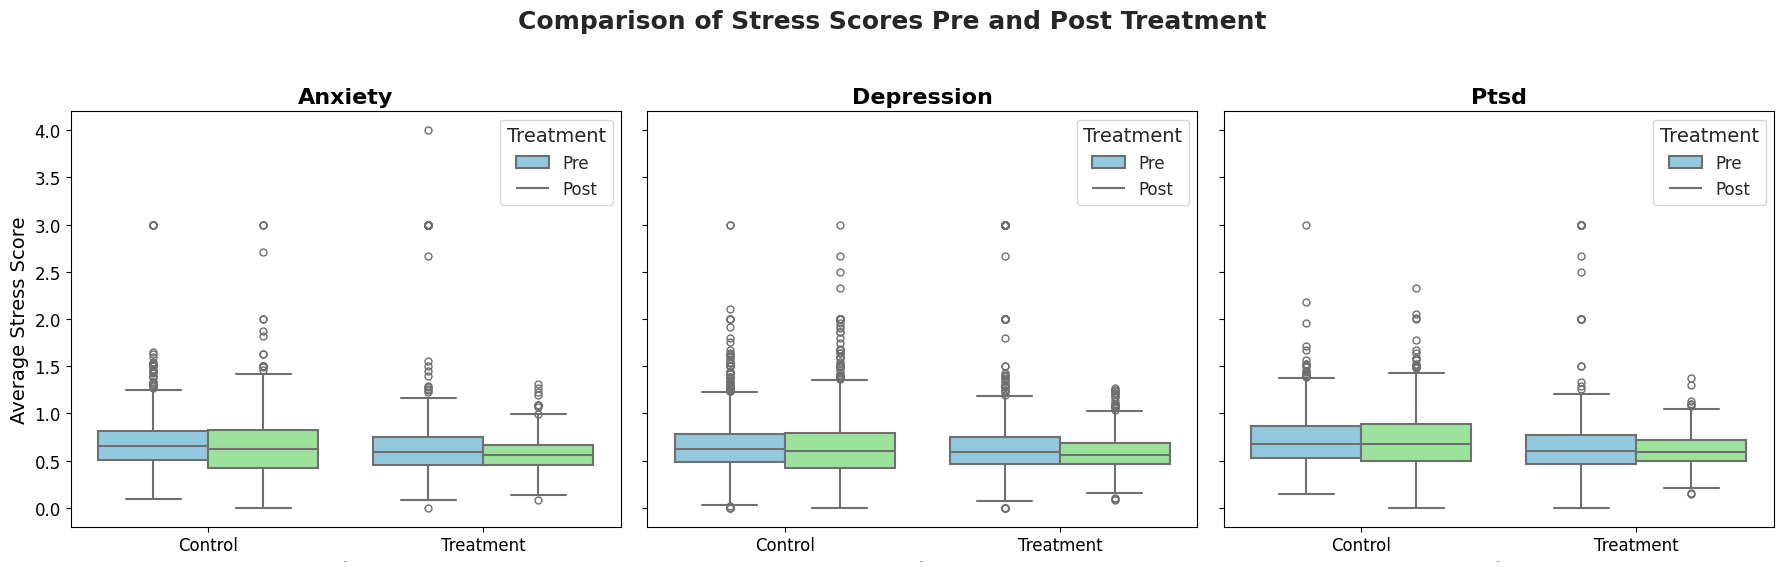

In [ ]:
# Calculate pre- and post-treatment average stress scores per user
def calculate_avg_scores(df):
    preTreatment = df[df['created_at'] < df['treatment_date']].groupby(['disorder', 'author_id']).agg(pre_avg_stress_score=('stress_score', 'mean')).reset_index()
    postTreatment = df[df['created_at'] >= df['treatment_date']].groupby(['disorder', 'author_id']).agg(post_avg_stress_score=('stress_score', 'mean')).reset_index()

    # Merge the pre and post data
    avgScores = pd.merge(preTreatment, postTreatment, on=['disorder', 'author_id'])
    avgScores = pd.merge(avgScores, df[['author_id', 'group']].drop_duplicates(), on='author_id')
    return avgScores

avgScoresDf = calculate_avg_scores(masterDf)

def plot_avg_stress_score_boxplots(df):
    disorders = ['anxiety', 'depression', 'ptsd']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    sns.set(style="whitegrid", palette="muted")

    for i, disorder in enumerate(disorders):
        disorderDf = df[df['disorder'] == disorder]
        disorderDfMelted = disorderDf.melt(id_vars=['author_id', 'group'], value_vars=['pre_avg_stress_score', 'post_avg_stress_score'],
                                              var_name='Time', value_name='Avg_Stress_Score')
        sns.boxplot(x='group', y='Avg_Stress_Score', hue='Time', data=disorderDfMelted, ax=axes[i],
                    palette={"pre_avg_stress_score": "skyblue", "post_avg_stress_score": "lightgreen"},
                    fliersize=5, linewidth=1.5)

        axes[i].set_title(f'{disorder.capitalize()}', fontsize=16, fontweight='bold')
        axes[i].set_xlabel('Group', fontsize=0)
        axes[i].set_ylabel('Average Stress Score', fontsize=14 if i == 0 else 0)
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Control', 'Treatment'], fontsize=12)
        axes[i].tick_params(axis='y', labelsize=12)
        axes[i].legend(title='Treatment', labels=['Pre', 'Post'], fontsize=12, title_fontsize=14)

    plt.suptitle('Comparison of Stress Scores Pre and Post Treatment', fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Create box plots for average stress scores
plot_avg_stress_score_boxplots(avgScoresDf)

#### Histograms

In [ ]:
# Aggregate stress scores by user and calculate mean stress score
avgStressScores = masterDf.groupby(['author_id', 'disorder', 'group'])['stress_score'].mean().reset_index()
# Update group with Control & Treatment
avgStressScores['group'] = avgStressScores['group'].replace({0: 'Control', 1: 'Treatment'})

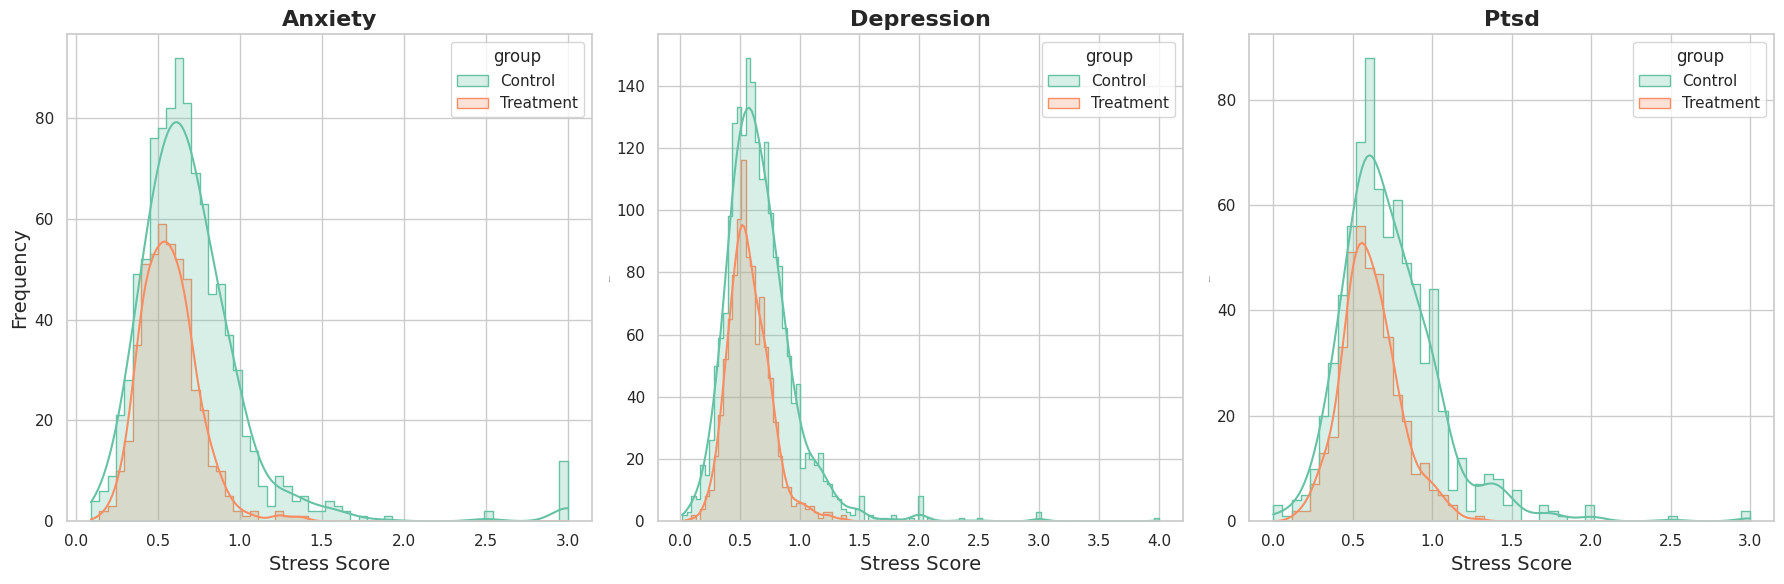

In [ ]:
# Plotting histograms for each disorder and group
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
sns.set(style="whitegrid", palette="muted")
#palette = {'Control': 'tab:blue', 'Treatment': 'tab:orange'}

# Loop through each disorder
for i, disorder in enumerate(['anxiety', 'depression', 'ptsd']):
    # Filter data for the current disorder and group
    sns.histplot(data=avgStressScores[avgStressScores['disorder'] == disorder],
                 x='stress_score',
                 hue='group',
                 kde=True,
                 legend=True,
                 element='step',
                 #bins=20, alpha=0.7,
                 palette="Set2",
                 hue_order=['Control', 'Treatment'],
                 ax=axes[i])
    # Plot
    axes[i].set_title(f'{disorder.capitalize()}', fontsize=16, fontweight='bold')
    axes[i].set_xlabel('Stress Score', fontsize=14)
    axes[i].set_ylabel('Frequency', fontsize=14 if i == 0 else 0)
    #axes[i].legend(title='Group', labels = ['Control', 'Treatment'], fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()

#### Scatter & Difference Histograms
pre vs. post treatment

In [ ]:
# Calculate pre-treatment and post-treatment periods
masterDf['pre_post_treatment'] = masterDf.apply(lambda row: 'pre' if row['created_at'] < row['treatment_date'] else 'post', axis=1)
# Aggregate average stress score per user for pre and post-treatment periods
avgStressPrePost = masterDf.groupby(['author_id', 'disorder', 'group', 'pre_post_treatment'])['stress_score'].mean().reset_index()
# Pivot table to get pre and post stress scores in separate columns
stressPivot = avgStressPrePost.pivot_table(index=['author_id', 'disorder', 'group'], columns='pre_post_treatment', values='stress_score').reset_index()
# Update group values to control and treatment
stressPivot['group'] = stressPivot['group'].replace({0: 'Control', 1: 'Treatment'})
# Find the pre/post difference
stressPivot['difference'] = stressPivot['post'] - stressPivot['pre']

<ipython-input-22-0989946f385c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masterDf['pre_post_treatment'] = masterDf.apply(lambda row: 'pre' if row['created_at'] < row['treatment_date'] else 'post', axis=1)


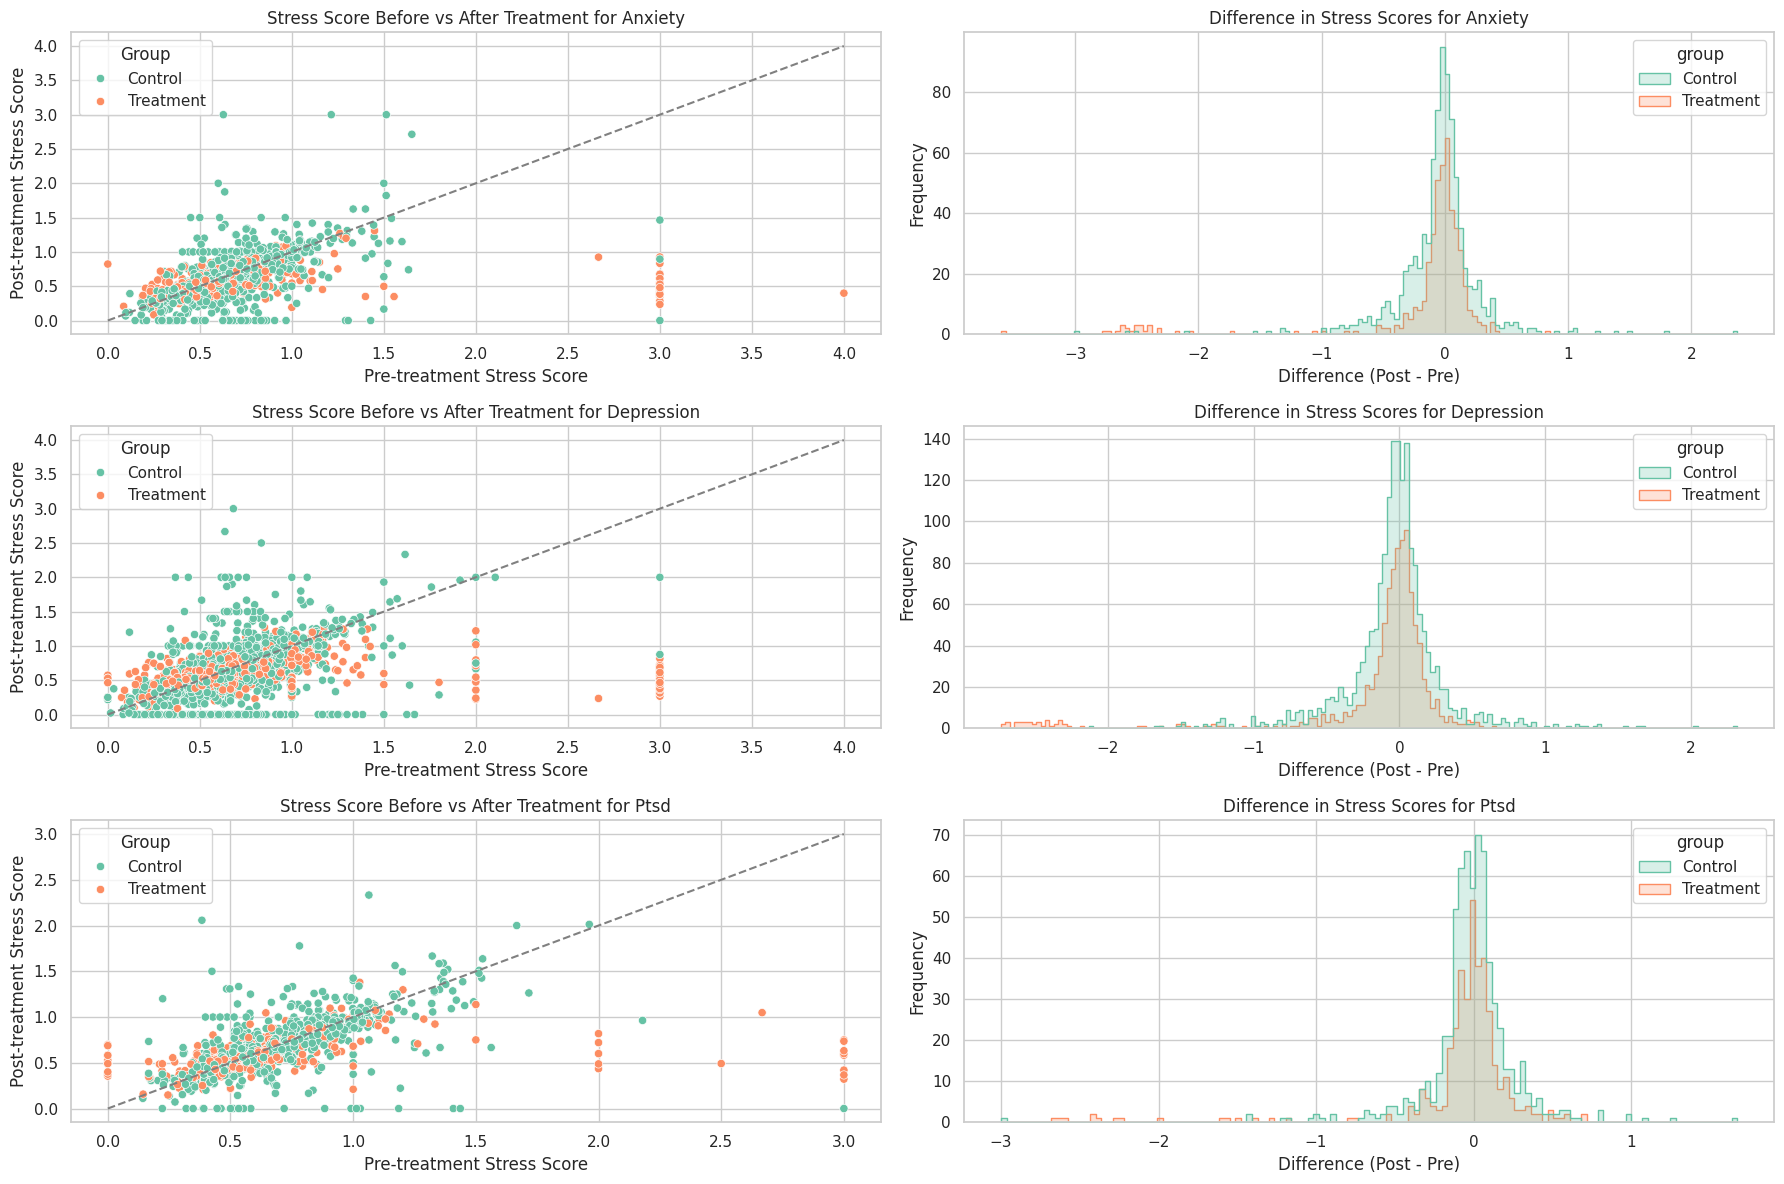

In [ ]:
# Plotting
plt.figure(figsize=(18, 12))

# Disorders list
disorders = ['anxiety', 'depression', 'ptsd']
#palette = {'Control': 'tab:blue', 'Treatment': 'tab:orange'}

for i, disorder in enumerate(disorders, 1):
    disorderData = stressPivot[stressPivot['disorder'] == disorder]

    # Paired Scatter Plot
    plt.subplot(3, 2, 2*i-1)
    sns.scatterplot(data=disorderData, x='pre', y='post', hue='group', palette="Set2")
    plt.plot([disorderData['pre'].min(), disorderData['pre'].max()], [disorderData['pre'].min(), disorderData['pre'].max()], color='grey', linestyle='--')
    plt.title(f'Stress Score Before vs After Treatment for {disorder.capitalize()}')
    plt.xlabel('Pre-treatment Stress Score')
    plt.ylabel('Post-treatment Stress Score')
    plt.legend(title='Group')#, labels=['Control', 'Treatment'])

    # Difference Histogram
    plt.subplot(3, 2, 2*i)
    sns.histplot(data=disorderData, x='difference', hue='group', element='step', palette="Set2", kde=False, legend=True)
    plt.title(f'Difference in Stress Scores for {disorder.capitalize()}')
    plt.xlabel('Difference (Post - Pre)')
    plt.ylabel('Frequency')
    # plt.legend(title='Group')#, fontsize=12, title_fontsize=14, labels=['Control', 'Treatment'])

plt.tight_layout()
plt.show()


#### Demographics

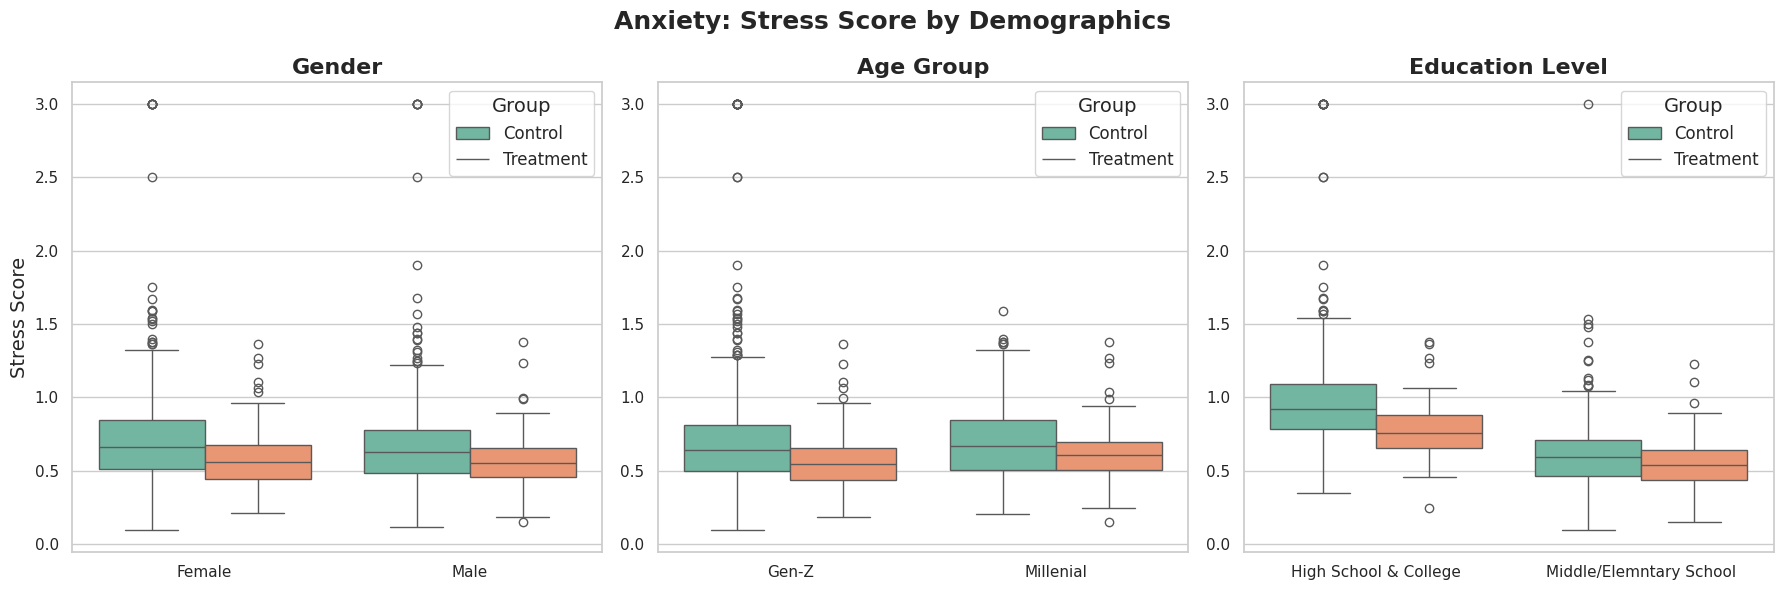

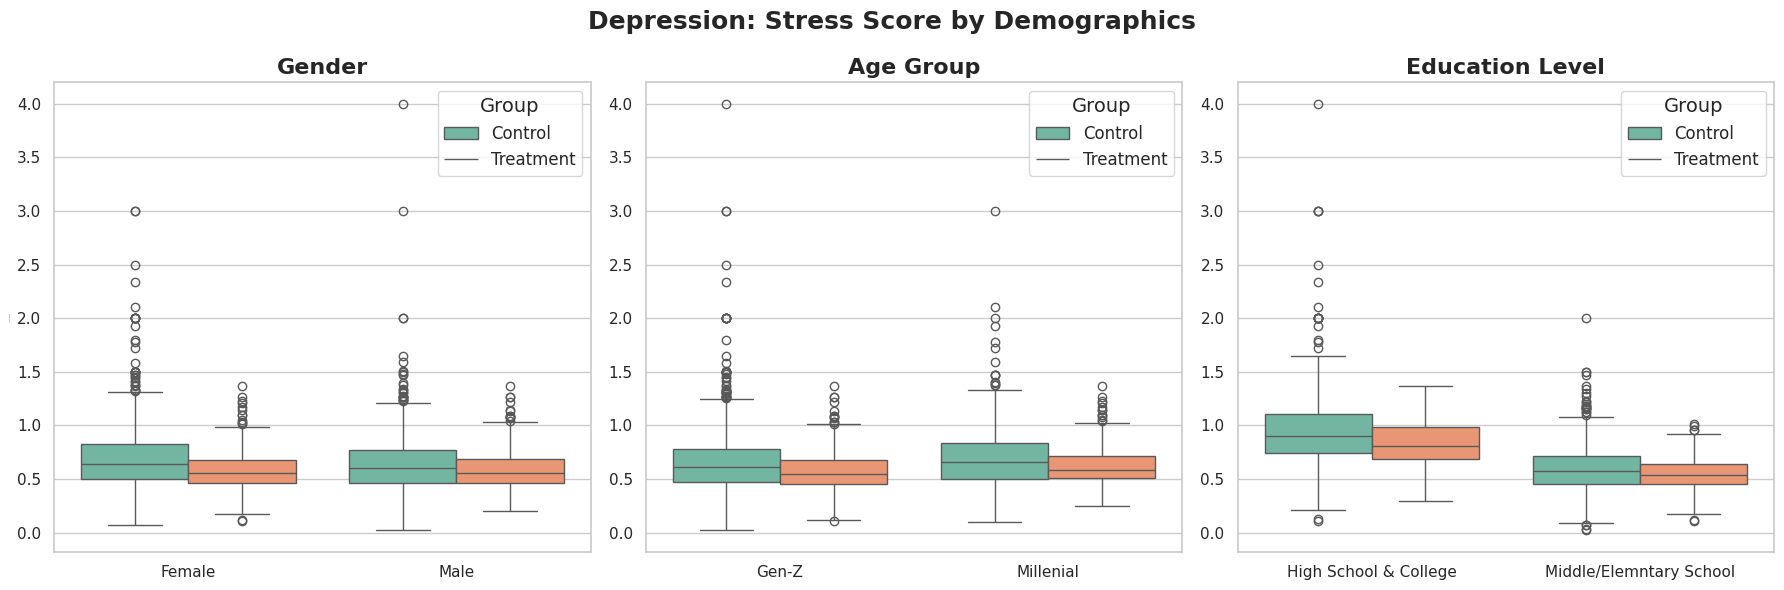

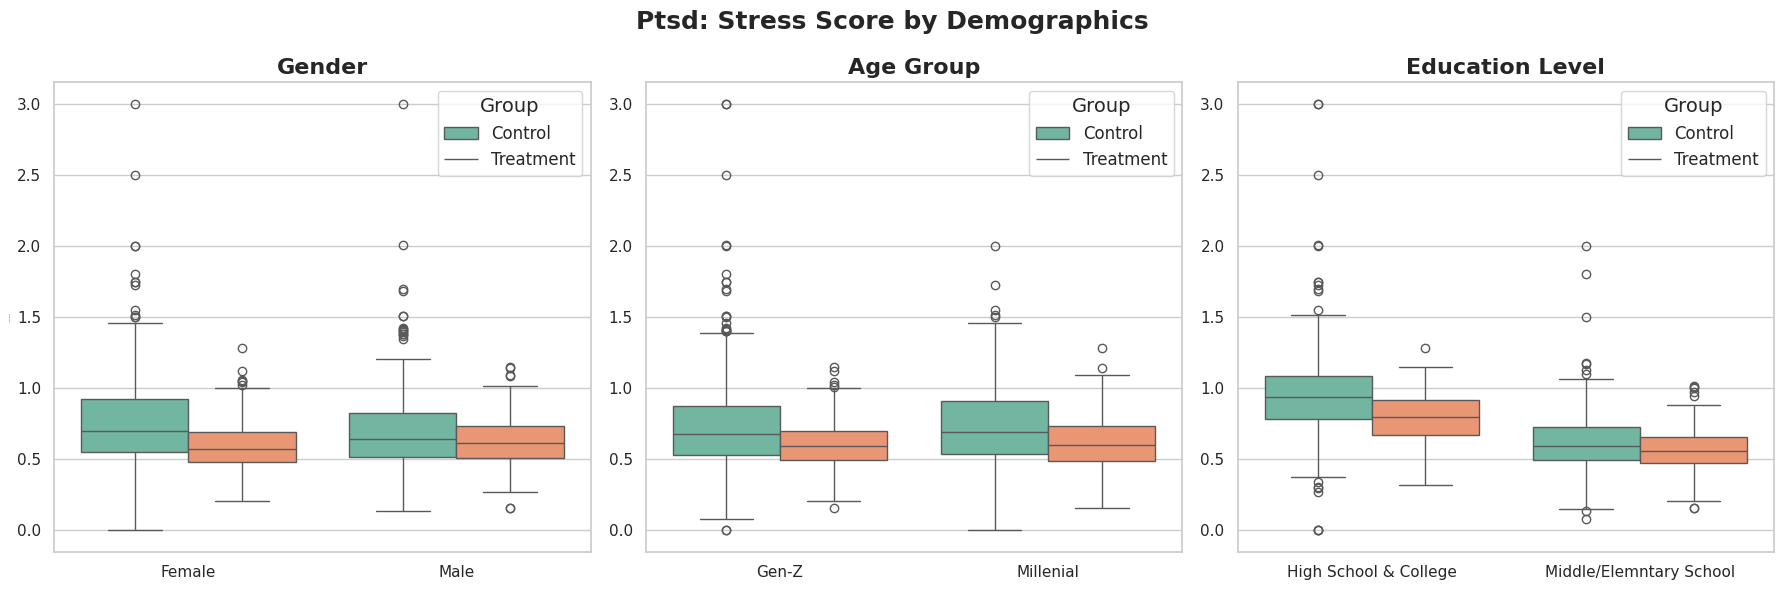

In [ ]:
# Aggregate stress scores by user and calculate mean stress score
avgStressScores = masterDf.groupby(['author_id', 'disorder', 'group', 'gender', 'age_group', 'edu_level'])['stress_score'].mean().reset_index()
avgStressScores.sort_values(by=['gender', 'age_group', 'edu_level'], inplace=True)
avgStressScores.reset_index(drop=True, inplace=True)

# Plotting box plots for each disorder and demographic variable
for i, disorder in enumerate(['anxiety', 'depression', 'ptsd']):

  fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
  sns.set(style="whitegrid", palette="muted")

  # Gender
  sns.boxplot(data=avgStressScores[avgStressScores.disorder == disorder], x='gender', y='stress_score', hue='group', palette='Set2', ax=axes[0])
  # Plot
  axes[0].set_title(f'Gender', fontsize=16, fontweight='bold')
  axes[0].set_xlabel('', fontsize=14)
  axes[0].set_ylabel('Stress Score', fontsize=14 if i == 0 else 0)
  axes[0].legend(title='Group', labels=['Control', 'Treatment'], fontsize=12, title_fontsize=14)

  # Age Group
  sns.boxplot(data=avgStressScores[avgStressScores.disorder == disorder], x='age_group', y='stress_score', hue='group', palette='Set2', ax=axes[1])
  # Plot
  axes[1].set_title(f'Age Group', fontsize=16, fontweight='bold')
  axes[1].set_xlabel('', fontsize=0)
  axes[1].set_ylabel('', fontsize=0)
  axes[1].legend(title='Group', labels=['Control', 'Treatment'], fontsize=12, title_fontsize=14)

  # Education Level
  sns.boxplot(data=avgStressScores[avgStressScores.disorder == disorder], x='edu_level', y='stress_score', hue='group', palette='Set2', ax=axes[2])
  # Plot
  axes[2].set_title(f'Education Level', fontsize=16, fontweight='bold')
  axes[2].set_xlabel('', fontsize=0)
  axes[2].set_ylabel('', fontsize=0)
  axes[2].legend(title='Group', labels=['Control', 'Treatment'], fontsize=12, title_fontsize=14)

  plt.suptitle(f'{disorder.capitalize()}: Stress Score by Demographics', fontsize=18, fontweight='bold')
  plt.tight_layout()
  plt.show()
